# Quantum Scripts

This notebook demonstrates various ways to use IBMs quantum computer. Also highlights aspects of a quantum computer, entanglement, noise, superposition.

## Very basic circuit to ensure I have it working correctly
Simple example from
https://docs.quantum.ibm.com/guides/hello-world

In [ ]:
TOKEN = ''

In [ ]:
!pip install qiskit
!pip install qiskit_ibm_runtime
!pip install pylatexenc

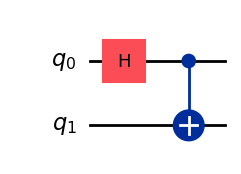

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Create a new circuit with two qubits
qc = QuantumCircuit(2)

# Add a Hadamard gate to qubit 0
qc.h(0)

# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

# Return a drawing of the circuit using MatPlotLib ("mpl").
qc.draw("mpl")

This very basic system will put q0 into a superposition state and then will entangle q0 and q1 with q0 as the control and q1 as the target

When creating quantum circuits, you must also consider what type of data you want returned after execution. Qiskit provides two ways to return data: you can obtain a probability distribution for a set of qubits you choose to measure, or you can obtain the expectation value of an observable. Prepare your workload to measure your circuit in one of these two ways with Qiskit primitives (explained in detail in Step 3).

This example measures expectation values by using the qiskit.quantum_info submodule, which is specified by using operators (mathematical objects used to represent an action or process that changes a quantum state). The following code cell creates six two-qubit Pauli operators: IZ, IX, ZI, XI, ZZ, and XX.

In [ ]:
# Set up six different observables.

observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

When executing circuits on a device, it is important to optimize the set of instructions that the circuit contains and minimize the overall depth (roughly the number of instructions) of the circuit. This ensures that you obtain the best results possible by reducing the effects of error and noise. Additionally, the circuit's instructions must conform to a backend device's Instruction Set Architecture (ISA) and must consider the device's basis gates and qubit connectivity.

The following code instantiates a real device to submit a job to and transforms the circuit and observables to match that backend's ISA.

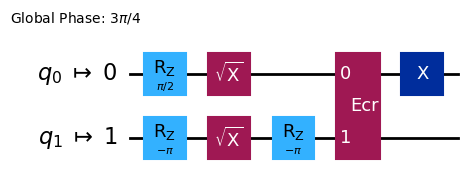

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# If you have not previously saved your credentials, follow instructions at
# https://docs.quantum.ibm.com/guides/setup-channel#iqp
# to authenticate with your API token.
service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN)

backend = service.least_busy(simulator=False, operational=True)

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw("mpl", idle_wires=False)

In [ ]:
# Construct the Estimator instance.

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cyyefny38jq0008ygnqg


In [ ]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()

# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

In [ ]:
print(job_result)

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,)), metadata={'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})


In [ ]:
print(pub_result)

PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,)), metadata={'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})


### Visualize

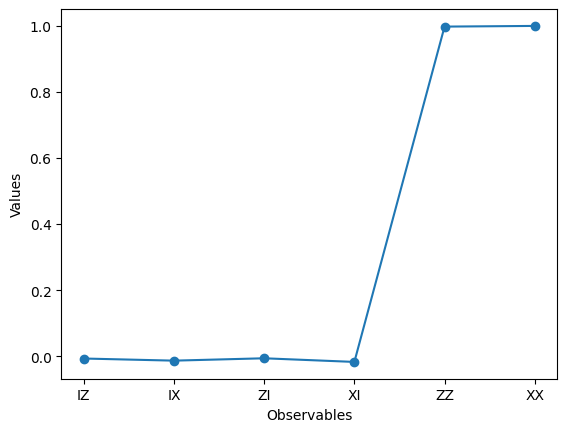

In [ ]:
# Plot the result

from matplotlib import pyplot as plt

values = pub_result.data.evs

errors = pub_result.data.stds

# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

OR RUN ON SIMULATOR

In [ ]:
# Use the following code instead if you want to run on a simulator:

from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
backend = FakeAlmadenV2()
estimator = Estimator(backend)

# Convert to an ISA circuit and layout-mapped observables.

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()

# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).

job_result = job.result()

# This is the result from our single pub, which had five observables,
# so contains information on all five.

pub_result = job.result()[0]

/usr/local/lib/python3.11/dist-packages/qiskit_ibm_runtime/fake_provider/fake_backend.py:468: RuntimeWarning: Aer not found, using qiskit.BasicSimulator and no noise.
  warnings.warn(


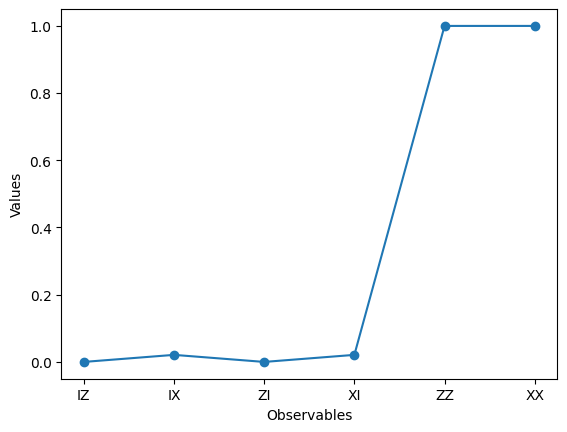

In [ ]:
# Plot the result

from matplotlib import pyplot as plt

values = pub_result.data.evs

errors = pub_result.data.stds

# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

## Simple example that shows probability outputs of only entanglement

Very simple circuit, it is only CNOT gates on two qubits being measured to two classical bits. Creates entanglement between the two qubits, no superposition of states though. This will show a "what we expect" the outcome to be will match the probability and then additional noise.

In [2]:
!pip install qiskit
!pip install qiskit_ibm_runtime
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.

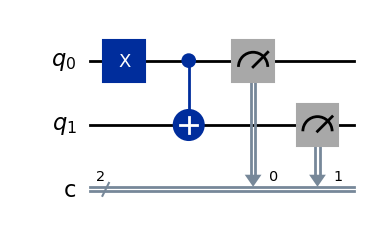

In [8]:
from qiskit import QuantumCircuit


circuit = QuantumCircuit(2,2)

# apply a NOT gate to qubit 0, currently 0,0
circuit.x(0)

# apply a CNOT gate, which flips 2nd qubit value if first qubit is a 1
circuit.cx(0, 1)
circuit.measure([0, 1], [0, 1])
circuit.draw("mpl")

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService(channel="ibm_quantum", token="c2057072d433f3ce68a82028273eef91069ed76c216063aa360f504f870009385e0efb72f0ebf9bf0f25c4be0460b0649fe6c4ccdb728ac263196064f222ff09")

backend = service.least_busy(simulator=False, operational=True)
print(backend)

<IBMBackend('ibm_kyiv')>


In [ ]:
from qiskit_ibm_runtime import SamplerV2
from qiskit import transpile
ibm_qcomp = service.backend('ibm_kyiv')

# Submit the job using SamplerV2
sampler = SamplerV2(ibm_qcomp)

circuit_transpile = transpile(circuit, ibm_qcomp)

job = sampler.run([(circuit_transpile, None, 1000)])
print(job.job_id())

# Get the results
result = job.result()

In [5]:
job_done = service.job('cz09h9dq2bag008yake0')
results = job_done.result()


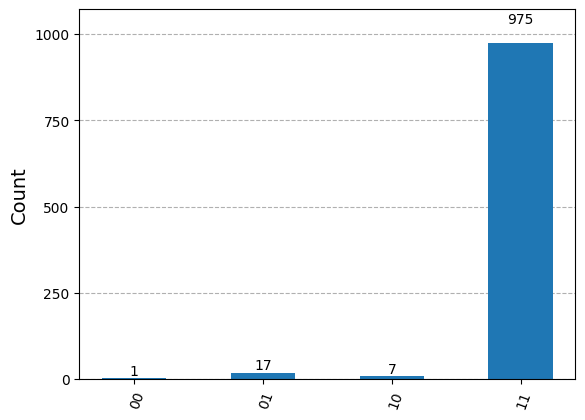

In [7]:
from qiskit.visualization import plot_histogram
counts = results[0].data.c.get_counts()
plot_histogram(counts)

This shows the expected output of performing a Not on the 0 state. Then a CNOT on the now 01 state to give 11.

|00> -> |01> -> |11>

This simple circuit creates an entanglement where the state of q0 has a direct affect on the state of q1. No superposition though so the state is a constant meaning we can view the expected effects of the circuit very easily. The extra outputs are due to noise associated with the qubits in the quantum computer.

## Shows example of probability outputs of a state in superposition and entanglement on quantum runtime

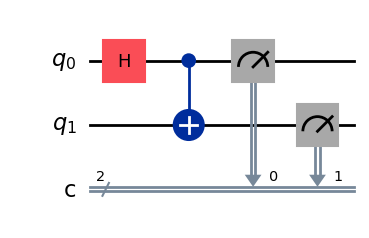

In [12]:
from qiskit import QuantumCircuit

# Create a new circuit with two qubits
qc = QuantumCircuit(2,2)

# Add a Hadamard gate to qubit 0
qc.h(0)

# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
qc. measure([0, 1], [0, 1])

# Return a drawing of the circuit using MatPlotLib ("mpl").
qc.draw("mpl")


### **Initial State**
All qubits start in the **|00⟩** state:
$$
|q_1 q_0\rangle = |00\rangle
$$

---

### **Hadamard Gate on Qubit 0**
Applying the Hadamard gate to **q₀:**

$$
H |0\rangle = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)
$$

Since q₁ remains **|0⟩**, the full system state is:
$$
|q_1 q_0\rangle = |0\rangle \otimes \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)
$$

Expanding the tensor product:
$$
|q_1 q_0\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |01\rangle)
$$

---

### **CNOT Gate (q₀ is control, q₁ is target)**
The **CNOT gate** flips q₁ **only if q₀ = |1⟩**.  
This transforms the state as follows:

$$
\frac{1}{\sqrt{2}} (|00\rangle + |01\rangle)
$$

Since the CNOT targets q₁ and flips it when q₀ is **|1⟩**, the state transitions to:

$$
\frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)
$$

Now, q₀ and q₁ are **entangled**.

---

### **Measurement**
When measured, the state collapses into either:
- **|00⟩** with probability **1/2**
- **|11⟩** with probability **1/2**

This means that:
- If **q₀ = 0**, then **q₁ = 0**.
- If **q₀ = 1**, then **q₁ = 1**.

---

### **Final State Before Measurement**
The final quantum state before measurement is:
$$
\frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)
$$
which is the **Bell state**.

---

So statistically, the result is **either |00⟩ or |11⟩, but never |01⟩ or |10⟩**.


In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN)

backend = service.least_busy(simulator=False, operational=True)
print(backend)

<IBMBackend('ibm_kyiv')>


In [13]:
from qiskit_ibm_runtime import SamplerV2
from qiskit import transpile

ibm_qcomp = service.backend('ibm_kyiv')

# Submit the job using SamplerV2
sampler = SamplerV2(ibm_qcomp)

circuit_transpile = transpile(qc, ibm_qcomp)

job = sampler.run([(circuit_transpile, None, 1000)])
print(job.job_id())

# Get the results
result = job.result()

cz0c73mnr89g0080bssg


In [14]:
job_done = service.job('cz0c73mnr89g0080bssg')
results = job_done.result()

In [15]:
results

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([SliceSpan(<start='2025-02-27 19:57:06', stop='2025-02-27 19:57:17', size=1000>)])}, 'version': 2})

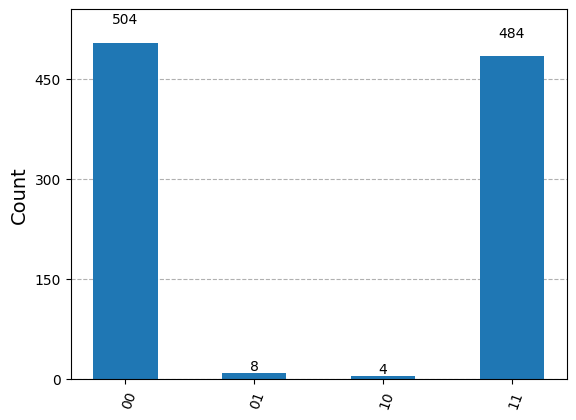

In [16]:
from qiskit.visualization import plot_histogram
counts = results[0].data.c.get_counts()
plot_histogram(counts)

Which is an interesting result because like mentioned above, the only possible results are 00 and 11. The 01 and 10 show the effects of quantum noise in a quantum computer.

## Circuit from class assignment that encorporates superposition and entanglement

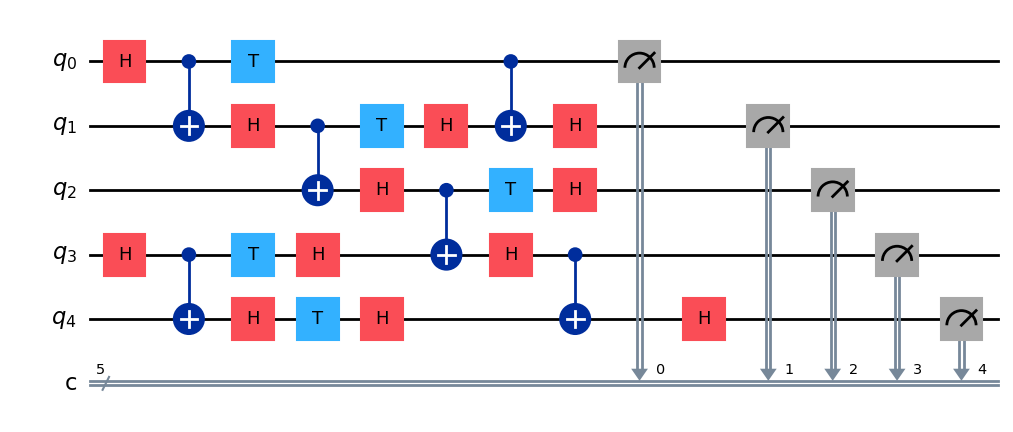

In [18]:
from qiskit import QuantumCircuit
bigger_circuit = QuantumCircuit(5,5)
# Circuit layers
bigger_circuit.h(0)
bigger_circuit.h(3)
bigger_circuit.cx(0, 1)
bigger_circuit.cx(3, 4)
bigger_circuit.h(1)
bigger_circuit.h(4)
bigger_circuit.t(0)
bigger_circuit.cx(1, 2)
bigger_circuit.t(3)
bigger_circuit.t(4)
bigger_circuit.h(2)
bigger_circuit.h(3)
bigger_circuit.t(1)
bigger_circuit.cx(2, 3)
bigger_circuit.h(1)
bigger_circuit.h(3)
bigger_circuit.h(4)
bigger_circuit.cx(0, 1)
bigger_circuit.t(2)
bigger_circuit.cx(3, 4)
bigger_circuit.h(1)
bigger_circuit.h(2)
bigger_circuit.h(4)

# Measurement
bigger_circuit.measure(range(5), range(5))
bigger_circuit.draw("mpl")

In [19]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN)
backend = service.least_busy(simulator=False, operational=True)
print(backend)

<IBMBackend('ibm_kyiv')>


In [20]:
from qiskit_ibm_runtime import SamplerV2
from qiskit import transpile

ibm_qcomp = service.backend('ibm_kyiv')

# Submit the job using SamplerV2
sampler = SamplerV2(ibm_qcomp)

circuit_transpile = transpile(bigger_circuit, ibm_qcomp)

job = sampler.run([(circuit_transpile, None, 1000)])
print(job.job_id())

# Get the results
result = job.result()

cz0ck95ccdf0008h9jd0


In [21]:
job_done = service.job('cz0ck95ccdf0008h9jd0')
results = job_done.result()

In [23]:
results

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=5>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([SliceSpan(<start='2025-02-27 20:23:04', stop='2025-02-27 20:23:16', size=1000>)])}, 'version': 2})

In [25]:
results[0]

SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=5>)), metadata={'circuit_metadata': {}})

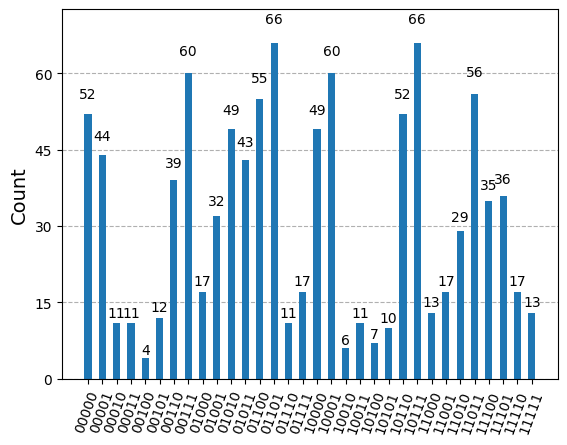

In [22]:
from qiskit.visualization import plot_histogram
counts = results[0].data.c.get_counts()
plot_histogram(counts)